# General

## Useful Sites
https://towardsdatascience.com/a-short-review-of-covid-19-data-sources-ba7f7aa1c342

https://ourworldindata.org/coronavirus

In [1]:
import urllib3

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy as np
import pandas as pd
import datetime
import time




## Models

### Basic definitions

> Prevlance:  measure of amount of disease in the population at a particular point in time.  In the context of COVID-19 there are two prevalence measures of note:  prevalence of infectious individuals and prevalence of infected individuals.  Total cases are indication of the prevalence of infected individuals. In both cases, we will use cases per million population as the metric.  New cases is indicative of actively infected individuals

> Incidence: measures probability of disease occurence during a given period.  In our context we are interested in the incidence of COVID-19 infections.  There is no direct measurement of incidence in the COVID-19 data

> Incidence Proportion:  Number of new cases in a time period. divided by the population initally at risk

> Incidence Rate: frequency of disease occurence over a specified time period.  Denomitator is person-time at risk.




### Daily Tests and Daily New Cases

All of the data available records (eithe directly or via a simple difference calculation on the cumulative total cases) the daily new cases.  The number of new cases seen on a hiven day is a function of the inci

In [2]:
from src import PopulationData

In [3]:
pop_data = PopulationData.from_csv("population_data.csv")
print(pop_data.get_population("Sweden"))
pop_data.df

10099270.0


,location,population,population_density,year
0,Afghanistan,3.892834e+07,59.627,2020
1,Africa,1.340598e+09,45.216,2020
2,African Group,1.338827e+09,45.571,2020
3,African Union,1.339424e+09,45.182,2020
4,African Union: Central Africa,1.586196e+08,30.066,2020
...,...,...,...,...
543,Washington,7.614893e+06,NaN,2019
544,West Virginia,1.792147e+06,NaN,2019
545,Wisconsin,5.822434e+06,NaN,2019
546,Wyoming,5.787590e+05,NaN,2019


In [4]:
print('Canada', pop_data.get_population('Canada'))
print('Ontario', pop_data.get_population('Ontario'))
print('Quebec', pop_data.get_population('Quebec'))
print('British Columbia', pop_data.get_population('British Columbia'))
print('Alberta', pop_data.get_population('Alberta'))

Canada 37742157.0
Ontario 14711827.0
Quebec 8537674.0
British Columbia 5110917.0
Alberta 4413146.0


In [5]:
# Red -> Green Color Map

cdict = {'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0))}

r_to_g_cmap = mcolors.LinearSegmentedColormap('Red_to_Green', cdict, 100)


# Set up map from doubling periods to growth rates
dbl_periods = {days: np.expm1(np.log(2) / days) for days in [2,3,4,5,6,7,14]}
def dbl_colour(days):
    return r_to_g_cmap(1 - (days / max(dbl_periods.keys())))



### Moving Average Rate of Change

In [6]:
def change(start, delta):
    if start > 0:
        return 1 + (delta / start)
    else:
        return 1
    
def growth_ma(tc, w=7):
    delta = tc[w:] - tc[: -w]
    return np.power([change(s, d) for s, d in zip(tc[: -w], delta)], 1 / w) - 1

def doubling_time(r):
    return np.log(2) / np.log1p(r)

### Predicting Total Cases from Confirmed Cases and Deaths

Variables:

* $p_{death}(k)$ probability of a patient dying from COVID-19 $k$ days after being infected
* $p_{icu}(k)$ probability of a patient requiring icu treatment $k$ days after infection
* $p_{symp}(k)$ probability that an infected individual shows symptoms $k$ days after infection

* incidence$(t)$ number of new cases per million at time $t$
* confirmed$(t)$ number of new confirmed cases per million at time $t$
* deaths$(t)$ number of deaths per million from COVID-19 at time $t$

We have datasets from most countries that give us confirmed and deaths time series.  The total case load is typically unknown.  

So the question is given $p_{death}$ and confirmed and deaths can we estimate incidence.

To do this we need to first estimate $p_{death}$

10.0 10.0 0.31622776601683794 0.1


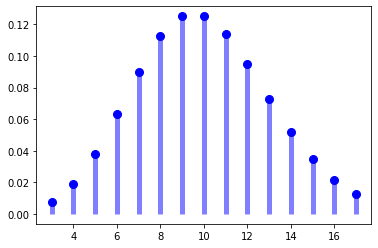

In [7]:
# Poisson Distribution

from scipy.stats import poisson
fig, ax = plt.subplots(1, 1)

mu = 10
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')
print(mean, var, skew, kurt)

x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

# World

In [8]:
# Get full European Centres for Disease Control dataset from OurWorldInData.org 
# (https://covid.ourworldindata.org/data/ecdc/full_data.csv)

ecdc_df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
ecdc_df_current_date = max(ecdc_df.date)
ecdc_df.rename

ecdc_df[ecdc_df.location == 'Canada']

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
6091,CAN,North America,Canada,2019-12-31,0.0,0.0,0.0,0.0,0.000,0.000,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
6092,CAN,North America,Canada,2020-01-01,0.0,0.0,0.0,0.0,0.000,0.000,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
6093,CAN,North America,Canada,2020-01-02,0.0,0.0,0.0,0.0,0.000,0.000,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
6094,CAN,North America,Canada,2020-01-03,0.0,0.0,0.0,0.0,0.000,0.000,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
6095,CAN,North America,Canada,2020-01-04,0.0,0.0,0.0,0.0,0.000,0.000,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6314,CAN,North America,Canada,2020-08-10,119451.0,245.0,8981.0,5.0,3164.922,6.491,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
6315,CAN,North America,Canada,2020-08-11,120117.0,666.0,8987.0,6.0,3182.569,17.646,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
6316,CAN,North America,Canada,2020-08-12,120406.0,289.0,8991.0,4.0,3190.226,7.657,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43
6317,CAN,North America,Canada,2020-08-13,120829.0,423.0,9006.0,15.0,3201.433,11.208,...,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43


location,World,Canada,China,United States,Italy,Spain,United Kingdom,Germany,Brazil
date,,,,,,,,,
2020-08-12,95.247,238.222,3.261,497.087,582.434,611.253,685.355,109.890,484.693
2020-08-13,96.151,238.619,3.263,501.588,582.599,611.809,688.006,109.938,490.221
2020-08-14,97.419,238.858,3.265,504.860,582.698,NaN,688.006,110.105,496.158


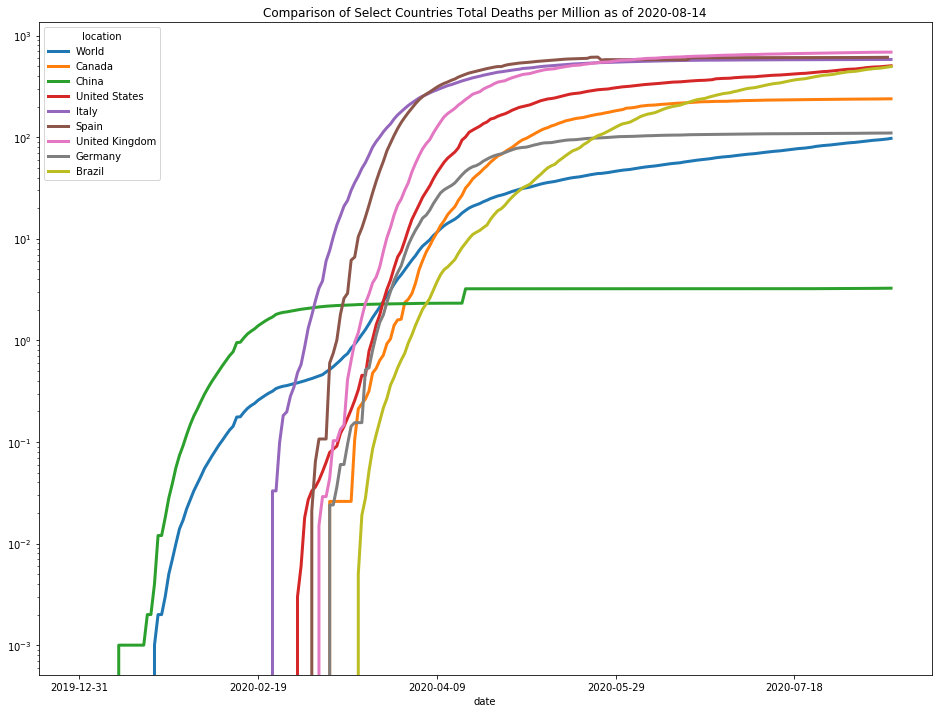

In [9]:
countries = ['World',
             'Canada', 
             'China', 
             'United States', 
             'Italy', 
             'Spain', 
             'United Kingdom', 
             'Germany',
             'Brazil']

ecdc_deaths = ecdc_df.pivot(index='date', columns='location', values='total_deaths_per_million')
ecdc_deaths[countries].plot(
    figsize=(16,12), 
    logy=True, 
    title=f"Comparison of Select Countries Total Deaths per Million as of {ecdc_df_current_date}",
    lw=3
)

ecdc_deaths[countries][-3:]

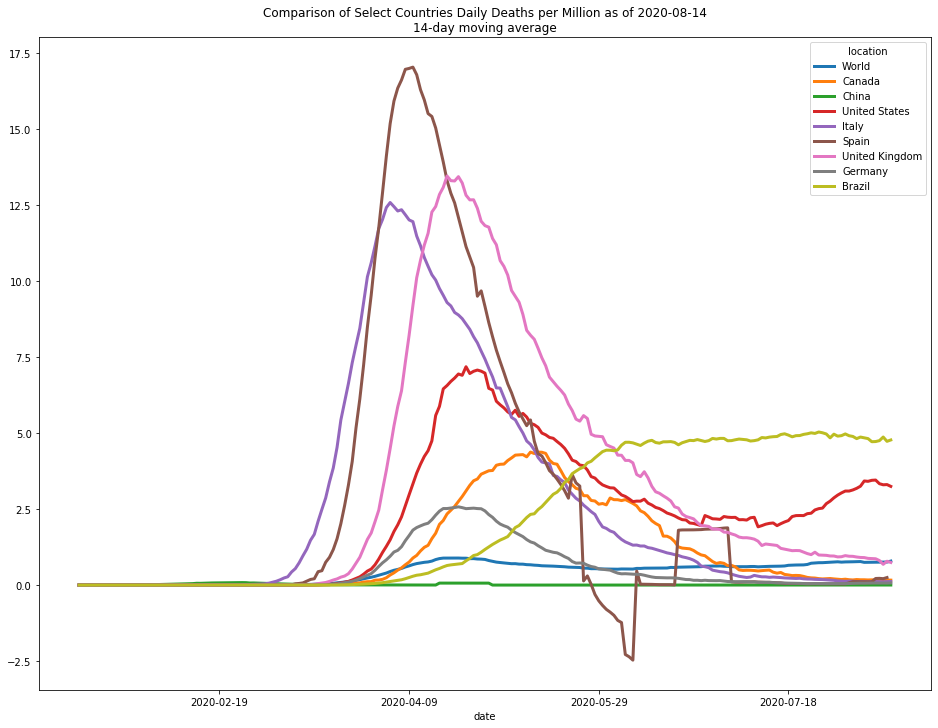

In [10]:
ecdc_dailydeaths = ecdc_df.pivot(index='date', columns='location', values='new_deaths_per_million')
ecdc_dailydeaths[countries].rolling(14).mean().plot(
    figsize=(16,12), 
    #logy=True, 
    title=f"Comparison of Select Countries Daily Deaths per Million as of {ecdc_df_current_date}\n14-day moving average",
    lw=3
)

savefile = f"{ecdc_df_current_date}_World_COVID-19_Daily_Death.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),format="png")

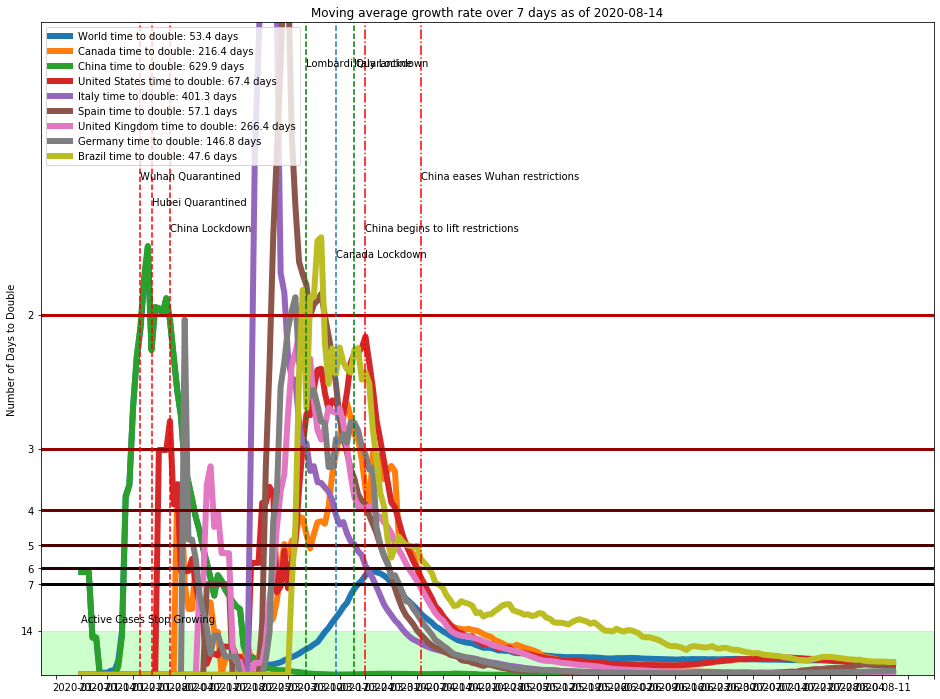

In [11]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)

window = 7

ax.set_title(f"Moving average growth rate over {window} days as of {ecdc_df_current_date}")
ax.set_ylabel("daily percent growth")

for country in countries:
    dates = ecdc_df[ecdc_df.location == country]['date'].values[window:]
    growth_rate = growth_ma(ecdc_df[ecdc_df.location == country]['total_cases'].values, window)
    label=f"{country} time to double: {doubling_time(growth_rate[-1]):.1f} days"
    #doubling = doubling_time(growth_rate)
    ax.plot(dates, growth_rate, label=label, lw=6)
    
for dbl_days, dbl_rate in dbl_periods.items():
    if dbl_days == 14:
        #ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=6)
        ax.axhspan(0, dbl_rate, color=dbl_colour(dbl_days), alpha=0.2)
    else:
        ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=3)
ax.set_yticks(list(dbl_periods.values()))
ax.set_yticklabels(list(dbl_periods.keys()))
ax.set_ylabel("Number of Days to Double")
    
ax.xaxis.set_major_locator(MultipleLocator(7))

# Italy
ax.axvline(x='2020-03-08', ls='--', c='green')  # Lombardi lockdown
ax.annotate("Lombardi Quarantine", ('2020-03-08', 0.7))
ax.axvline(x='2020-03-21', ls='--', c='green')  # Italy lockdown
ax.annotate("Italy Lockdown", ('2020-03-21', 0.7))

# Canada
ax.axvline(x='2020-03-16', ls='--')  # Canada lockdown
ax.annotate("Canada Lockdown", ('2020-03-16', 0.48))

# China
#ax.axvline(x='2020-01-01', ls='--', c='red')  # Wuhan Market Shutdown
#ax.annotate("Wuhan Market Shutdown", ('2020-01-01', 0.02))
ax.axvline(x='2020-01-23', ls='--', c='red')  # Wuhan Quarantine
ax.annotate("Wuhan Quarantined", ('2020-01-23', 0.57))
ax.axvline(x='2020-01-26', ls='--', c='red')  # Quarantine extended to Hubei 
ax.annotate("Hubei Quarantined", ('2020-01-26', 0.54))
ax.axvline(x='2020-01-31', ls='--', c='red')  # China lockdown
ax.annotate("China Lockdown", ('2020-01-31', 0.51))
ax.axvline(x='2020-03-24', ls='-.', c='red')  # China lifts lockdown
ax.annotate("China begins to lift restrictions", ('2020-03-24', 0.51))
ax.axvline(x='2020-04-08', ls='-.', c='red')  # China lifts lockdown
ax.annotate("China eases Wuhan restrictions", ('2020-04-08', 0.57))

ax.annotate("Active Cases Stop Growing", (dates[0], 0.06))

ax.legend(loc='upper left')
plt.ylim(bottom=0, top=0.75)
savefile = f"{ecdc_df_current_date}_World_COVID-19_Growth_{window}_days.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),format="png")
plt.show()

In [12]:
ecdc_deaths[country]

date
2019-12-31      0.000
2020-01-01      0.000
2020-01-02      0.000
2020-01-03      0.000
2020-01-04      0.000
               ...   
2020-08-10    475.392
2020-08-11    478.699
2020-08-12    484.693
2020-08-13    490.221
2020-08-14    496.158
Name: Brazil, Length: 228, dtype: float64

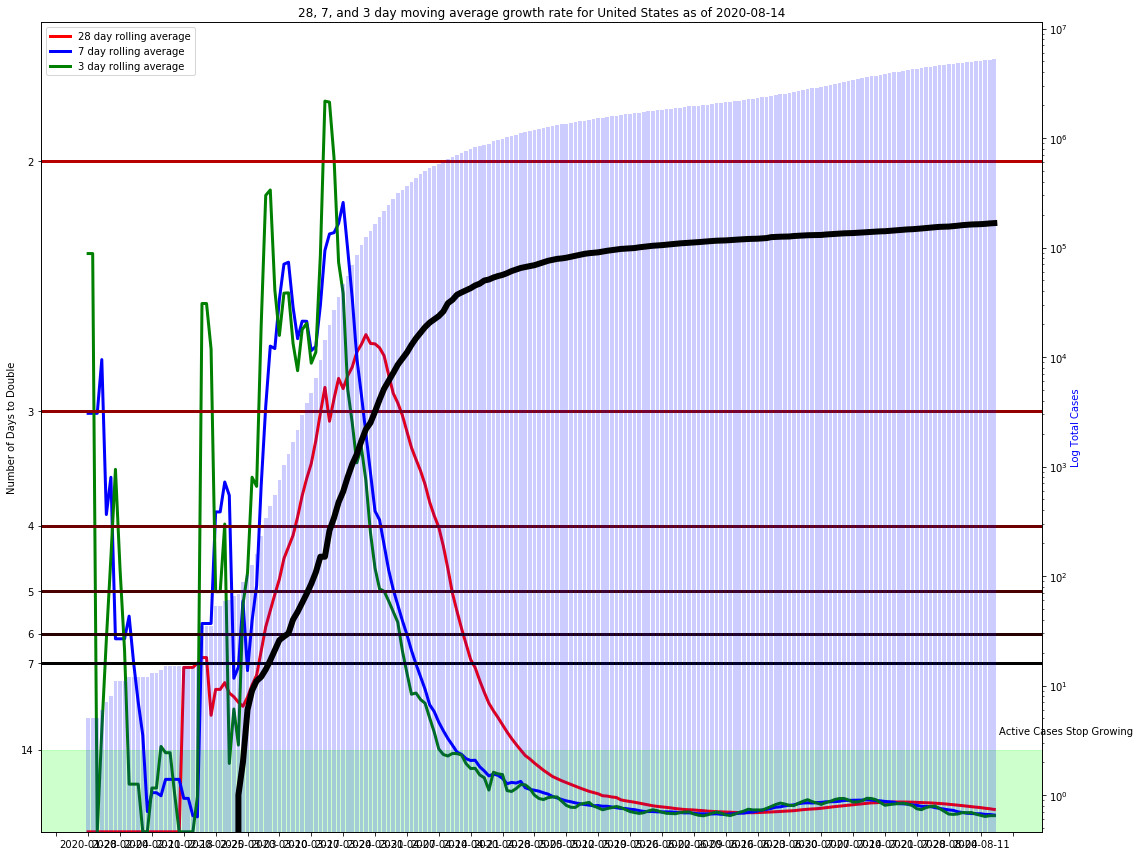

In [13]:
# Single Country
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)

country = 'United States'

ax.set_title(f"28, 7, and 3 day moving average growth rate for {country} as of {ecdc_df_current_date}")
ax.set_ylabel("Growth Rate in Doubling Time")

dates = ecdc_df[ecdc_df.location == country]['date'].values
#growth_rate = growth_ma(ecdc_df[ecdc_df.location == country]['total_cases'].values, window)
#doubling = doubling_time(growth_rate)
ax.plot(dates[28:], 
        growth_ma(ecdc_df[ecdc_df.location == country]['total_cases'].values, 28), 
        label="28 day rolling average", c='r', lw=3)
ax.plot(dates[28:], 
        growth_ma(ecdc_df[ecdc_df.location == country]['total_cases'].values, 7)[21:], 
        label="7 day rolling average", c='b', lw=3)
ax.plot(dates[28:], 
        growth_ma(ecdc_df[ecdc_df.location == country]['total_cases'].values, 3)[25:], 
        label="3 day rolling average", c='g', lw=3)




new_cases = ecdc_df[ecdc_df.location == country]['new_cases'].values
total_cases = ecdc_df[ecdc_df.location == country]['total_cases'].values
ax_r = ax.twinx()
ax_r.bar(dates[28:], total_cases[28:], color=(0,0,1, 0.2))
ax_r.plot(dates[28:], ecdc_df[ecdc_df.location == country][28:]['total_deaths'],
          label="Total deaths", c='black', lw=6)
ax_r.set_ylabel('Log Total Cases', color='b')
ax_r.set_yscale('log')
    
for dbl_days, dbl_rate in dbl_periods.items():
    if dbl_days == 14:
        #ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=6)
        ax.axhspan(0, dbl_rate, color=dbl_colour(dbl_days), alpha=0.2)
    else:
        ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=3)
ax.set_yticks(list(dbl_periods.values()))
ax.set_yticklabels(list(dbl_periods.keys()))
ax.set_ylabel("Number of Days to Double")
    
ax.xaxis.set_major_locator(MultipleLocator(7))

ax.annotate("Active Cases Stop Growing", (dates[0], 0.06))

ax.legend(loc='upper left')
ax.set_ylim(bottom=0, top=0.5)
fig.tight_layout()
plt.show()

# Comparison of National Responses

Throughout this pandemic, countries have employed various measures to control the spread of the virus.  These measures aim to achieve one or more of the following goals:

* G1: reduce the rate of importation of the infection into the country
* G2: reduce the rate of spread between geographically seperated communities within the country
* G3: reduce the rate of spread within a community
* G4: reduce the rate of spread to vulnerable populations
* G5: reduce the case fatality rate

While the specific details of the measures implemented in each country vary significantly Measures fall into two broad categories control and surveilance.  Control measures can be the following categories:

* C1: national border restrictions
* C2: internal movement restrictions (e.g. municipal, provincial border restrictions, closing community spaces, shelter in place)
* C3: cquarantine
* C4: business closures
* C5: health care system capacity augmentation
* C6: institutional infection control measures
* C7: public infection control measures (e.g. masks, handwashing, physical distancing)
* C8: diagnostic testing (i.e., testing focused on identifying treatment course)
* C9: testing as entitlement criteria (e.g. requiring negative test results prior to entering a health care institution)

Surveilance measures include:
* S1: contact tracing
* S2: surveilance testing
* S3: disease modelling (using available test data)

Implementation of measures also varies.  Implementation options are:
* I1: voluntary
* I2: voluntary with active facilitation (e.g. housing options for homeless, income support)
* I3: mandatory with education and sanctions reserved for egregess violation
* I4: mandatory with active administrative sanction
* I5: mandatory with criminal sanction


## Canada and US

## Canada and South Korea

## Canada and Germany

## Canada and Sweden

## US and Russia

# Canada

Data from Public Health Agency: 
https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html#a1

Population data from Stats Can:
"https://www150.statcan.gc.ca/n1/pub/91-002-x/2019004/quarterly_trimestrielles_202001_v1.xlsx"

## Get Canada Data

In [14]:
# Set up metadata
provinces = ['Canada', 
             'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 
             'Quebec',
             'Ontario', 
             'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia',
             'Yukon', 'Northwest Territories', 'Nunavut']

large_provinces = ['Canada', 'British Columbia', 'Ontario', 'Quebec']
maritimes = ['Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick']
prairies = ['Manitoba', 'Saskatchewan', 'Alberta']

prov_colours = dict(zip(provinces, 
                        ['r', 
                        'darkred', 'salmon', 'darksalmon', 'sienna', 
                        'cornflowerblue',
                        'b',
                        'gold', 'goldenrod', 'darkgoldenrod', 'g',
                        'olive', 'chartreuse', 'darkseagreen']
                       )
                   )

# Set Moving Average Window Size
ma_window = 7

# Display history
history = 60


# Get dataset from PHAC
dateparse = lambda x: datetime.date(*time.strptime(x, '%d-%m-%Y')[:3])
can_df = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19.csv",
                     error_bad_lines=False, 
                     warn_bad_lines=False, 
                     parse_dates=['date'],
                     date_parser= dateparse)

can_df = can_df.loc[can_df.prname != 'Repatriated travellers']
can_df.reindex()

# Create total cases dataset
can_tc = can_df.pivot(index='date', columns='prname', values='numtotal').fillna(0)
can_tc = can_tc.resample('D').fillna(method='ffill')
can_current_date = can_tc.index[-1].date()

# Create new cases column from total cases
can_nc = can_tc.diff()
can_nc_df = can_nc.stack()
can_nc_df.rename('numtoday', inplace=True)

can_df = can_df.join(can_nc_df, on=['date', 'prname'], lsuffix='_old')
can_df.drop('numtoday_old', axis='columns')

# Create total death dataset
can_td = can_df.pivot(index='date', columns='prname', values='numdeaths').fillna(0)
can_td = can_td.resample('D').fillna(method='ffill')

# Create new deaths column from total deaths
can_nd = can_td.diff()
can_nd_df = can_nd.stack()
can_nd_df.rename('newdeaths', inplace=True)

can_df = can_df.join(can_nd_df, on=['date', 'prname'], lsuffix='_old')

# Create total tested dataset
can_tt = can_df.pivot(index='date', columns='prname', values='numtested').fillna(0)
can_tt = can_tt.resample('D').fillna(method='ffill')

# Create new deaths column from total deaths
can_nt = can_tt.diff()
can_nt_df = can_nt.stack()
can_nt_df.rename('newtests', inplace=True)

can_df = can_df.join(can_nt_df, on=['date', 'prname'], lsuffix='_old')
can_df = can_df.drop(['numtoday_old'], axis=1)

can_df.tail(13)

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,...,percentactive,numactive,rateactive,numtotal_last14,ratetotal_last14,numdeaths_last14,ratedeaths_last14,numtoday,newdeaths,newtests
2383,48,Alberta,Alberta,2020-08-13,11969,0,220.0,11969,647281.0,10713.0,...,8.66,1036.0,23.70,1253.0,28.66,25.0,0.57,76.0,3.0,5411.0
2384,47,Saskatchewan,Saskatchewan,2020-08-13,1511,0,20.0,1511,100386.0,1325.0,...,10.99,166.0,14.13,205.0,17.45,2.0,0.17,27.0,0.0,1496.0
2385,46,Manitoba,Manitoba,2020-08-13,603,0,8.0,603,105705.0,377.0,...,36.15,218.0,15.92,194.0,14.17,0.0,0.00,25.0,0.0,1711.0
2386,35,Ontario,Ontario,2020-08-13,40367,0,2787.0,40367,2416582.0,36689.0,...,2.21,891.0,6.12,1292.0,8.87,15.0,0.10,78.0,0.0,28657.0
2387,24,Quebec,Québec,2020-08-13,60917,0,5715.0,60917,939144.0,53441.0,...,2.89,1761.0,20.75,1786.0,21.05,42.0,0.49,104.0,6.0,12606.0
2388,10,Newfoundland and Labrador,Terre-Neuve-et-Labrador,2020-08-13,268,0,3.0,268,27834.0,263.0,...,0.75,2.0,0.38,2.0,0.38,0.0,0.00,0.0,0.0,261.0
2389,13,New Brunswick,Nouveau-Brunswick,2020-08-13,180,0,2.0,180,49032.0,169.0,...,5.00,9.0,1.16,10.0,1.29,0.0,0.00,2.0,0.0,231.0
2390,12,Nova Scotia,Nouvelle-Écosse,2020-08-13,1071,0,64.0,1071,68441.0,1007.0,...,0.00,0.0,0.00,4.0,0.41,0.0,0.00,0.0,0.0,467.0
2391,11,Prince Edward Island,Île-du-Prince-Édouard,2020-08-13,41,0,0.0,41,22645.0,36.0,...,12.20,5.0,3.19,5.0,3.19,0.0,0.00,0.0,0.0,264.0
2392,60,Yukon,Yukon,2020-08-13,15,0,0.0,15,2112.0,15.0,...,0.00,0.0,0.00,1.0,2.45,0.0,0.00,0.0,0.0,50.0


In [15]:
# Add Confirmed Case per Test Ratio Column
can_df["postestratio"] = can_df["numtotal"] / can_df["numtested"]

can_pt = can_df.pivot(index='date', columns='prname', values='postestratio').fillna(0)
can_pt = can_pt.resample('D').fillna(method='ffill')

# Create growth of positive test rate dataset
can_pt_growth_dict = {
    prov: growth_ma(can_pt[prov].values, ma_window) for prov in provinces
}
can_pt_growth_df = pd.DataFrame(can_pt_growth_dict, index=can_pt.index[ma_window:])

can_pt[provinces][-7:]

prname,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-08-07,0.027245,0.010102,0.001728,0.016048,0.003690,0.067763,0.017578,0.005085,0.015088,0.018639,0.016582,0.008170,0.001657,0.0
2020-08-08,0.027071,0.010027,0.001693,0.015966,0.003673,0.067412,0.017416,0.005251,0.015118,0.018639,0.016402,0.008170,0.001657,0.0
2020-08-09,0.026856,0.009941,0.001665,0.015927,0.003659,0.066559,0.017248,0.005613,0.015000,0.018639,0.016308,0.008170,0.001657,0.0
2020-08-10,0.026665,0.009909,0.001651,0.015879,0.003642,0.066165,0.017139,0.005519,0.014886,0.018513,0.016614,0.007649,0.001657,0.0
2020-08-11,0.026514,0.009818,0.001642,0.015815,0.003646,0.065831,0.017001,0.005489,0.015076,0.018500,0.016692,0.007437,0.001627,0.0
2020-08-12,0.026379,0.009720,0.001832,0.015756,0.003647,0.065635,0.016872,0.005558,0.015007,0.018529,0.016893,0.007274,0.001614,0.0
2020-08-13,0.026156,0.009629,0.001811,0.015649,0.003671,0.064864,0.016704,0.005705,0.015052,0.018491,0.017014,0.007102,0.001609,0.0


In [16]:
can_tt[provinces][-7:]

prname,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-08-07,4367208.0,26431.0,20831.0,66739.0,47695.0,889002.0,2269714.0,96553.0,93388.0,613221.0,237247.0,1836.0,3017.0,1458.0
2020-08-08,4404038.0,26629.0,21258.0,67080.0,47911.0,895496.0,2294872.0,96553.0,94786.0,613221.0,239845.0,1836.0,3017.0,1458.0
2020-08-09,4447810.0,26859.0,21616.0,67245.0,48106.0,908532.0,2321735.0,96553.0,96331.0,613221.0,241225.0,1836.0,3017.0,1458.0
2020-08-10,4505218.0,27045.0,21805.0,67446.0,48330.0,916301.0,2343281.0,101101.0,97404.0,631295.0,244680.0,1961.0,3017.0,1476.0
2020-08-11,4541747.0,27298.0,21922.0,67720.0,48553.0,922332.0,2364157.0,102391.0,98105.0,636319.0,246281.0,2017.0,3073.0,1503.0
2020-08-12,4581083.0,27573.0,22381.0,67974.0,48801.0,926538.0,2387925.0,103994.0,98890.0,641870.0,248385.0,2062.0,3097.0,1517.0
2020-08-13,4635105.0,27834.0,22645.0,68441.0,49032.0,939144.0,2416582.0,105705.0,100386.0,647281.0,251210.0,2112.0,3107.0,1550.0


In [17]:
# Create total case growth rate dataset
can_growth_dict = {
    prov: growth_ma(can_tc[prov].values, ma_window) for prov in provinces
}
can_growth_df = pd.DataFrame(can_growth_dict, index=can_tc.index[ma_window:])

# Create total death growth rate dataset
can_td_growth_dict = {
    prov: growth_ma(can_td[prov].values, ma_window) for prov in provinces
}
can_td_growth_df = pd.DataFrame(can_td_growth_dict, index=can_tc.index[ma_window:])


In [18]:
can_tc[-21:][provinces]

prname,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-07-24,113206.0,265.0,36.0,1067.0,170.0,58243.0,38405.0,384.0,1099.0,10086.0,3419.0,14.0,5.0,0.0
2020-07-25,113556.0,265.0,36.0,1067.0,170.0,58414.0,38543.0,388.0,1136.0,10086.0,3419.0,14.0,5.0,0.0
2020-07-26,113911.0,266.0,36.0,1067.0,170.0,58583.0,38680.0,394.0,1178.0,10086.0,3419.0,14.0,5.0,0.0
2020-07-27,114597.0,266.0,36.0,1067.0,170.0,58728.0,38799.0,400.0,1209.0,10390.0,3500.0,14.0,5.0,0.0
2020-07-28,114994.0,266.0,36.0,1067.0,170.0,58897.0,38910.0,405.0,1218.0,10470.0,3523.0,14.0,5.0,0.0
2020-07-29,115406.0,266.0,36.0,1067.0,170.0,59009.0,38986.0,407.0,1268.0,10603.0,3562.0,14.0,5.0,0.0
2020-07-30,115799.0,266.0,36.0,1067.0,170.0,59131.0,39075.0,409.0,1306.0,10716.0,3591.0,14.0,5.0,0.0
2020-07-31,116312.0,266.0,36.0,1069.0,170.0,59312.0,39209.0,415.0,1319.0,10843.0,3641.0,14.0,5.0,0.0
2020-08-01,116599.0,266.0,36.0,1069.0,170.0,59458.0,39333.0,417.0,1334.0,10843.0,3641.0,14.0,5.0,0.0


In [19]:
can_td[-7:][provinces]

prname,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-08-07,8970.0,3.0,0.0,64.0,2.0,5687.0,2783.0,8.0,20.0,208.0,195.0,0.0,0.0,0.0
2020-08-08,8976.0,3.0,0.0,64.0,2.0,5692.0,2784.0,8.0,20.0,208.0,195.0,0.0,0.0,0.0
2020-08-09,8981.0,3.0,0.0,64.0,2.0,5695.0,2786.0,8.0,20.0,208.0,195.0,0.0,0.0,0.0
2020-08-10,8987.0,3.0,0.0,64.0,2.0,5696.0,2786.0,8.0,20.0,213.0,195.0,0.0,0.0,0.0
2020-08-11,8991.0,3.0,0.0,64.0,2.0,5697.0,2786.0,8.0,20.0,216.0,195.0,0.0,0.0,0.0
2020-08-12,9006.0,3.0,0.0,64.0,2.0,5709.0,2787.0,8.0,20.0,217.0,196.0,0.0,0.0,0.0
2020-08-13,9015.0,3.0,0.0,64.0,2.0,5715.0,2787.0,8.0,20.0,220.0,196.0,0.0,0.0,0.0


In [20]:
can_nc[-7:][provinces]

prname,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-08-07,424.0,1.0,0.0,0.0,0.0,108.0,88.0,17.0,22.0,134.0,53.0,1.0,0.0,0.0
2020-08-08,236.0,0.0,0.0,0.0,0.0,126.0,70.0,16.0,24.0,0.0,0.0,0.0,0.0,0.0
2020-08-09,230.0,0.0,0.0,0.0,0.0,104.0,79.0,35.0,12.0,0.0,0.0,0.0,0.0,0.0
2020-08-10,681.0,1.0,0.0,0.0,0.0,156.0,115.0,16.0,5.0,257.0,131.0,0.0,0.0,0.0
2020-08-11,289.0,0.0,0.0,0.0,1.0,91.0,33.0,4.0,29.0,85.0,46.0,0.0,0.0,0.0
2020-08-12,423.0,0.0,5.0,0.0,1.0,95.0,95.0,16.0,5.0,121.0,85.0,0.0,0.0,0.0
2020-08-13,390.0,0.0,0.0,0.0,2.0,104.0,78.0,25.0,27.0,76.0,78.0,0.0,0.0,0.0


In [21]:
# population
can_pop_df = pd.read_excel(
    "https://www150.statcan.gc.ca/n1/pub/91-002-x/2019004/quarterly_trimestrielles_202001_v1.xlsx",
    sheet_name="Population",
    header=[3],
    skiprows=[4]
)

pr_mapper = {'Canada': 'Canada', 
             'N.L.': 'Newfoundland and Labrador', 
             'P.E.I.': 'Prince Edward Island', 
             'N.S.': 'Nova Scotia', 
             'N.B.': 'New Brunswick', 
             'Que.': 'Quebec',
             'Ont.': 'Ontario', 
             'Man.': 'Manitoba',
             'Sask.': 'Saskatchewan', 
             'Alta.': 'Alberta', 
             'B.C.': 'British Columbia', 
             'Y.T.': 'Yukon', 
             'N.W.T.': 'Northwest Territories', 
             'Nvt.': 'Nunavut'}


can_pop_df.rename(columns=pr_mapper, inplace=True)
pop_2020 = can_pop_df.loc[can_pop_df.Year == 2020]

# Add population column to can_df
def get_pop(prov):
    if prov in can_pop_df.columns:
        return pop_2020[prov].values[0]
    else:
        return np.nan

can_df["population"] = can_df["prname"].apply(get_pop)

# Add Cases Per Million Population colmn to can_df
can_df["numpermillion"] = 1000000 * can_df["numtotal"] / can_df["population"]

# Create Cases per Million Dataset
can_cases_per_mil = can_df.pivot(index='date', 
                                 columns='prname', 
                                 values='numpermillion').fillna(0)
can_cases_per_mil = can_cases_per_mil.resample('D').fillna(method='ffill')

# Add Total Case Estimate Column
can_df["numcasesest"] = can_df["population"] * can_df["postestratio"]

# Create Total Cases Esitmate Dataset
can_caseload_df = can_df.pivot(index='date', 
                             columns='prname', 
                             values='numcasesest').fillna(0)
can_caseload_df = can_caseload_df.resample('D').fillna(method='ffill')

# Add Test Per Million column to can_df
can_df["testspermillion"] = 1000000 * can_df["numtested"] / can_df["population"]

# Create Tests Per Million Dataset
can_tests_per_mil = can_df.pivot(index='date', 
                                 columns='prname', 
                                 values='testspermillion')
can_tests_per_mil = can_tests_per_mil.resample('D').fillna(method='ffill')

#can_cases_per_mil = pd.DataFrame(
#    {prov: 1000000 * (can_tc[prov].values / pop_2020[prov].values) for prov in provinces},
#    index=can_tc.index
#)
    
pop_2020

,Year,Month,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut,Level
194,2020,1,37894799,521365,158158,977457,779993,8537674,14711827,1377517,1181666,4413146,5110917,41078,44904,39097.0,PP


In [22]:
can_df[can_df.date == str(can_current_date)]

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,...,numdeaths_last14,ratedeaths_last14,numtoday,newdeaths,newtests,postestratio,population,numpermillion,numcasesest,testspermillion
2382,59,British Columbia,Colombie-Britannique,2020-08-13,4274,0,196.0,4274,251210.0,3500.0,...,2.0,0.04,78.0,0.0,2825.0,0.017014,5110917.0,836.249151,86955.373027,49151.649303
2383,48,Alberta,Alberta,2020-08-13,11969,0,220.0,11969,647281.0,10713.0,...,25.0,0.57,76.0,3.0,5411.0,0.018491,4413146.0,2712.124185,81604.348767,146671.104922
2384,47,Saskatchewan,Saskatchewan,2020-08-13,1511,0,20.0,1511,100386.0,1325.0,...,2.0,0.17,27.0,0.0,1496.0,0.015052,1181666.0,1278.703119,17786.318072,84952.939325
2385,46,Manitoba,Manitoba,2020-08-13,603,0,8.0,603,105705.0,377.0,...,0.0,0.00,25.0,0.0,1711.0,0.005705,1377517.0,437.744144,7858.121669,76735.895092
2386,35,Ontario,Ontario,2020-08-13,40367,0,2787.0,40367,2416582.0,36689.0,...,15.0,0.10,78.0,0.0,28657.0,0.016704,14711827.0,2743.846838,245748.880240,164261.175719
2387,24,Quebec,Québec,2020-08-13,60917,0,5715.0,60917,939144.0,53441.0,...,42.0,0.49,104.0,6.0,12606.0,0.064864,8537674.0,7135.081522,553790.991646,109999.983602
2388,10,Newfoundland and Labrador,Terre-Neuve-et-Labrador,2020-08-13,268,0,3.0,268,27834.0,263.0,...,0.0,0.00,0.0,0.0,261.0,0.009629,521365.0,514.035273,5019.969103,53386.782772
2389,13,New Brunswick,Nouveau-Brunswick,2020-08-13,180,0,2.0,180,49032.0,169.0,...,0.0,0.00,2.0,0.0,231.0,0.003671,779993.0,230.771302,2863.410426,62862.102609
2390,12,Nova Scotia,Nouvelle-Écosse,2020-08-13,1071,0,64.0,1071,68441.0,1007.0,...,0.0,0.00,0.0,0.0,467.0,0.015649,977457.0,1095.700374,15295.750310,70019.448426
2391,11,Prince Edward Island,Île-du-Prince-Édouard,2020-08-13,41,0,0.0,41,22645.0,36.0,...,0.0,0.00,0.0,0.0,264.0,0.001811,158158.0,259.234436,286.353632,143179.605205


In [23]:
can_caseload_df

prname,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-01-31,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-03,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-04,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-09,82257.878938,83351.010376,1.017708e+06,7732.687892,2853.672473,5182.786217,74.418296,15567.796074,0.0,253754.120966,263.401554,568259.218667,17725.419335,335.604575
2020-08-10,81699.423094,84910.403813,1.010468e+06,7602.837618,2840.446265,5166.419671,74.418296,15521.401521,0.0,252142.907379,261.118459,564894.681549,17590.814546,314.212137
2020-08-11,81643.884140,85313.035870,1.004752e+06,7560.865252,2843.465100,5118.536889,73.062154,15458.600812,0.0,250121.787359,259.724843,562043.266342,17814.423465,305.488349


In [24]:
# Detailed death data

can_death_df = pd.read_csv(Path.home().joinpath("Downloads").joinpath("13100766.csv"))
can_deaths = can_death_df.pivot(index='Case identifier number', columns='Case information', values='VALUE')
can_deaths.describe()

/Users/bill/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Case information,Age group,Date case was last updated - day,Date case was last updated - month,Death,"Death, previous status",Episode date - day,Episode date - month,Gender,Hospitalization,"Hospitalization, previous status",Intensive care unit,"Intensive care unit, previous status",Transmission
count,14157.000000,14157.000000,14157.0,14157.000000,9658.000000,14157.000000,14157.000000,14157.000000,14157.000000,9658.000000,14157.000000,9658.000000,14157.000000
mean,7.982835,12.126722,4.0,5.335664,6.664837,16.581338,3.343364,1.595818,4.967083,5.168979,6.536837,6.742286,1.753055
std,17.254881,3.669181,0.0,3.526040,3.327645,9.255767,2.824577,0.800858,3.586365,3.608526,3.380420,3.311040,0.440808
min,1.000000,7.000000,4.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,7.000000,4.0,2.000000,2.000000,8.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,5.000000,15.000000,4.0,2.000000,9.000000,18.000000,3.000000,2.000000,2.000000,2.000000,9.000000,9.000000,2.000000
75%,6.000000,15.000000,4.0,9.000000,9.000000,24.000000,4.000000,2.000000,9.000000,9.000000,9.000000,9.000000,2.000000
max,99.000000,15.000000,4.0,9.000000,9.000000,99.000000,99.000000,9.000000,9.000000,9.000000,9.000000,9.000000,3.000000


### Graph - Canada Cumulative Total Confirmed Cases

Confirmed cases are driven by three factors:

#### The actual cumulative total of cases in the population.
The actual cumulative total of cases in the population is currently unknown. Blood tests capable of identifying antibodies will evenually allow us to estimate the true extent of the infection.

#### The test coverage;
Canada is reporting the number of people tested, so the test coverage can be computed.  

If people are selected at random for testing, we could estimate the actual cumulative total of cases by multiplying the positive test ratio by the population.  Unfortunately the world is not that simple.

#### The test strategy; 
Test strategy refers to the criteria used to select individuals for testing.  In Ontario for example, one must have travelled or been exposed to a known case and be experiencing key symptopms, as such testing is focused on higher risk individuals.  Consequently the positive test ratio ($\frac{\text{confirmed}}{\text{tested}}$) would be larger that the density of infection in the population ($\frac{\text{total_cases}}{\text{population}}$).  This makes an estimate of total cases an upper bound on the total number of cases.


<Figure size 432x288 with 0 Axes>

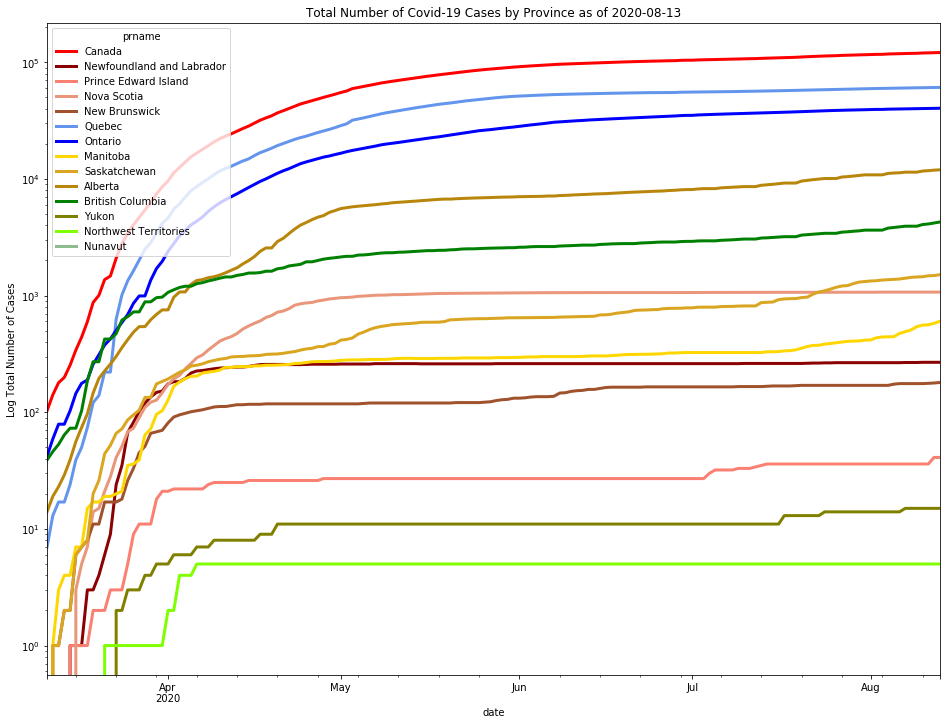

In [25]:
fig_can_tc = plt.figure()
fig_can_tc_ax = can_tc["2020-03-11":][provinces].plot(
    figsize=(16,12), 
    logy=True, 
    title=f"Total Number of Covid-19 Cases by Province as of {can_current_date}",
    color=prov_colours.values(),
    lw=3
)

fig_can_tc_ax.set_ylabel("Log Total Number of Cases")

plt.show()

### Graph - Tests per million

Canada is reporting the number of people tested so the ratio of the numtested to the population gives a good indication of test coverage

In [26]:
can_tt[provinces][-7:]
can_tt.to_csv("Canada_Total_Tests.csv")

<Figure size 432x288 with 0 Axes>

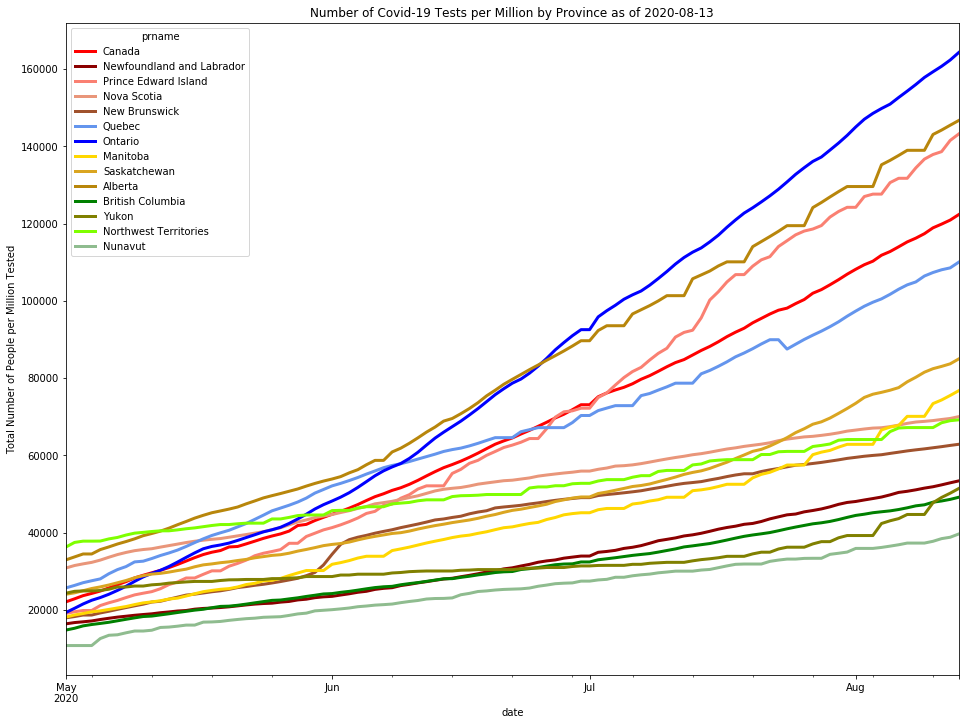

In [27]:
fig_can_testsrate = plt.figure()
fig_can_testrate_ax = can_tests_per_mil["2020-05-01":][provinces].plot(
    figsize=(16,12), 
    
    #logy=True, 
    title=f"Number of Covid-19 Tests per Million by Province as of {can_current_date}",
    color=prov_colours.values(),
    lw=3
)

fig_can_testrate_ax.set_ylabel("Total Number of People per Million Tested")

savefile = f"{can_current_date}_COVID-19_TestsPerMil.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")
plt.show()

### Graph - Positive Test Ratios

Let positive test rate at time, $t$, be $\text{pt}(t) = \frac{\text{new cases}}{\text{total persons tested}}$.  It is an indicator of the prevalence at time $t$.  It is an indicator rather than the true prevalence because the testing is not random. For Canada, who gets tested is different in each province, so some of the differences in rates is related to the details of how testing has been done. 

All provinces are limiting tests higher risk individuals.  Most provinces are only testing those presenting symptoms or those with greater exposure to the disease (e.g., travellers, health care workers, patients admitted to icu for respiratory disease).  This means that the cumulative positive test ratio likely overstates the prevalence.

Provinces also change their testing approach over time.  For example, Ontario has been narrowing its tests to those for whom test results will influence treatment.  This will cause the positive test rate to rise.  

This is not a perfect measure, but it does provide a better indication of how wide-spread the disease is.  With the caveates described above, higher positive test rates indicate a higher probability pf infection.

<Figure size 432x288 with 0 Axes>

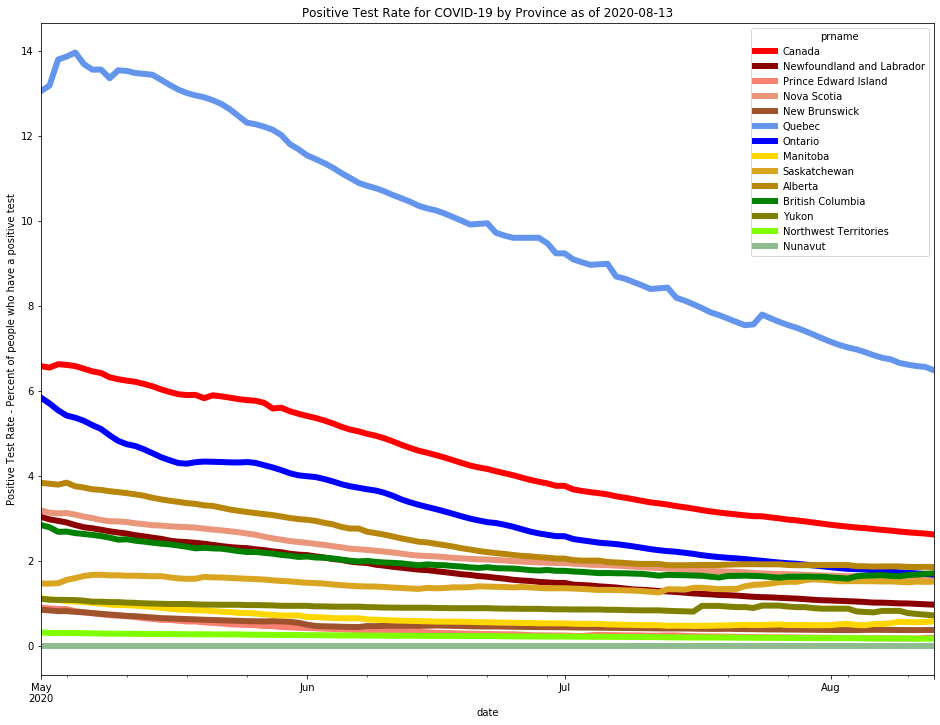

prname,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-08-13,2.615561,0.962851,0.181055,1.564851,0.367107,6.486439,1.670417,0.570456,1.50519,1.84912,1.701365,0.710227,0.160927,0.0


In [28]:
fig_can_pt = plt.figure()
fig_can_pt_ax = (can_pt.mul(100))["2020-05-01":][provinces].plot(
    figsize=(16,12), 
    #logy=True, 
    title=f"Positive Test Rate for COVID-19 by Province as of {can_current_date}",
    color=prov_colours.values(),
    lw=6
)

fig_can_pt_ax.set_ylabel("Positive Test Rate - Percent of people who have a positive test")

savefile = f"{can_current_date}_COVID-19_PosTestRate.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")


plt.show()

can_pt.mul(100)[-1:][provinces]

<Figure size 432x288 with 0 Axes>

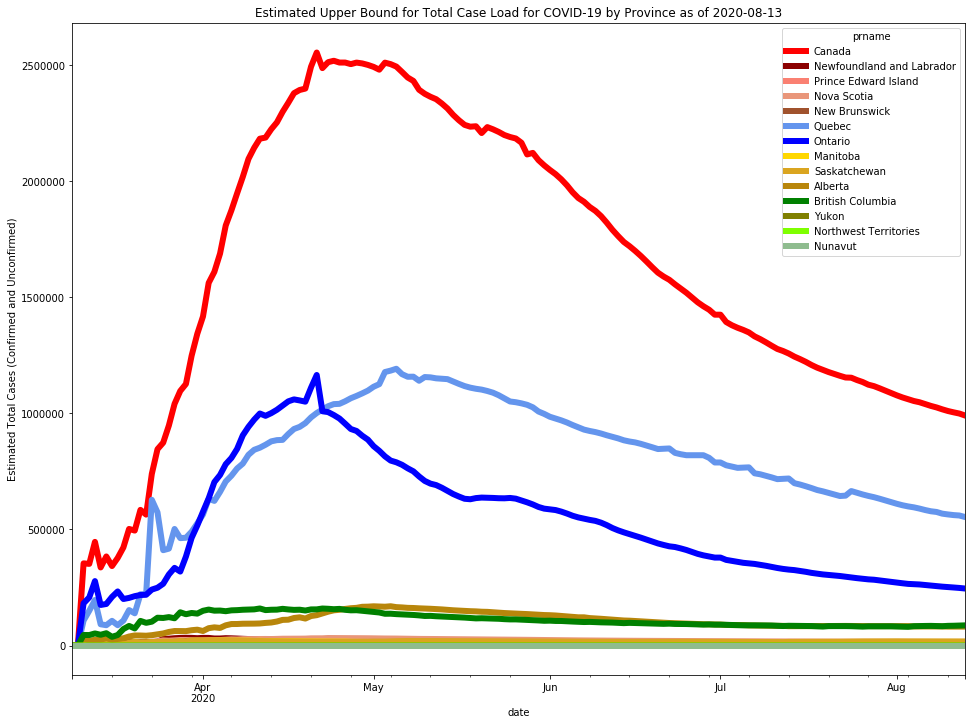

In [29]:
fig_can_pt = plt.figure()
fig_can_pt_ax = can_caseload_df["2020-03-09":][provinces].plot(
    figsize=(16,12), 
    #logy=True, 
    title=f"Estimated Upper Bound for Total Case Load for COVID-19 by Province as of {can_current_date}",
    color=prov_colours.values(),
    lw=6
)

fig_can_pt_ax.set_ylabel("Estimated Total Cases (Confirmed and Unconfirmed)")

savefile = f"{can_current_date}_COVID-19_Est_TotalCases.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

### Graph - Growth Rates

The can_growth_df dataset is derived from the daily cumulative totals of confirmed cases.  It provides a moving average of the rate of growth over a period.  (Typically, I have been looking at 7, 14, and 28 days.). Longer periods provide a better picture of the the future as they reflect the stable trend.  Shorter periods allow one to see the near term influence of events.

Total cases are analogous to the cumulative distance the disease has travelled.  Growth rates are analogous to the speed of travel over the preceeding period.

The growth rate, $r$ over a period of length, $w$  is caclulated as the solution to $(1 + r)^w = 2$, that is, 

$$r = (1 + \frac{\delta}{\text{start}})^\frac{1}{w}$$

where $\delta$ is the change over the period and start is the value at the start of the period.

Growth rates correspond to the number of days to double by the formula

$$\text{doubling_period} = \frac{\ln{2}}{\ln{(1 + r)}}$$

/Users/bill/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

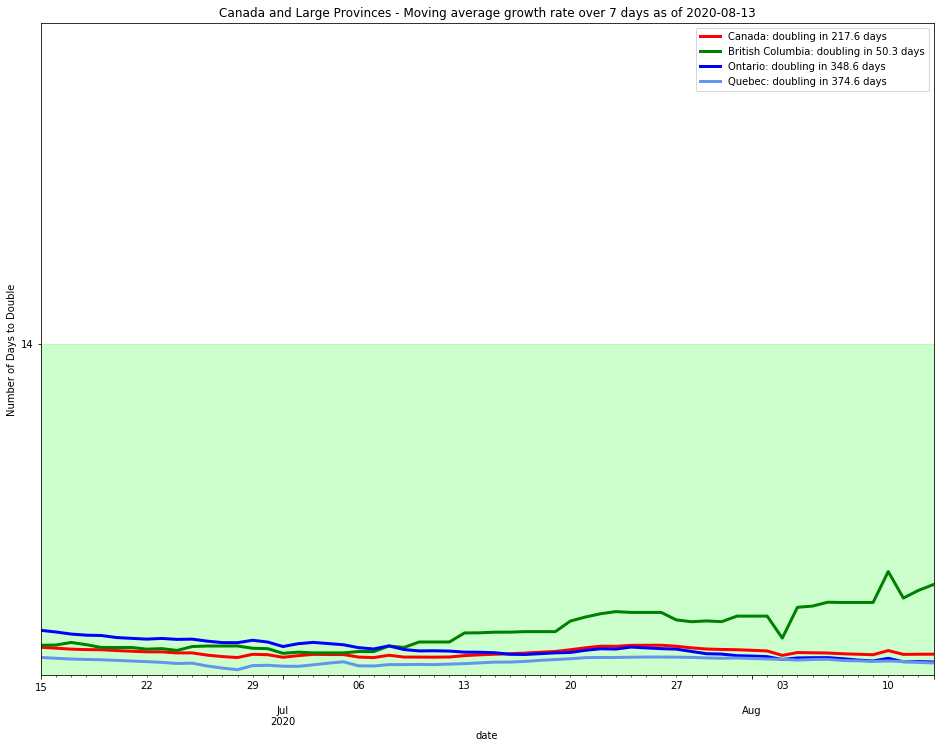

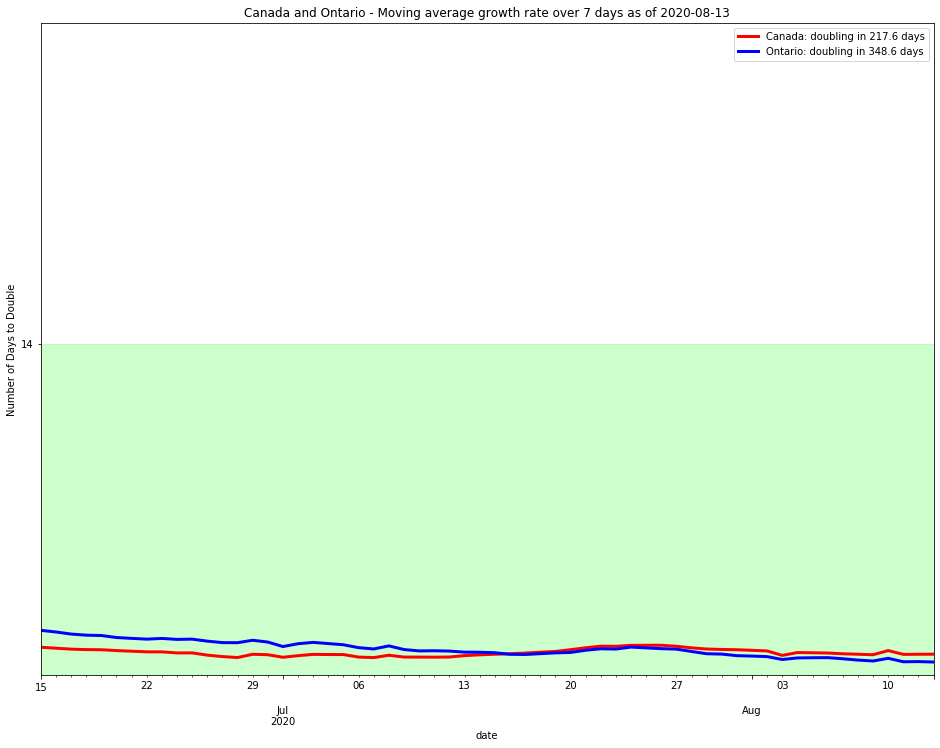

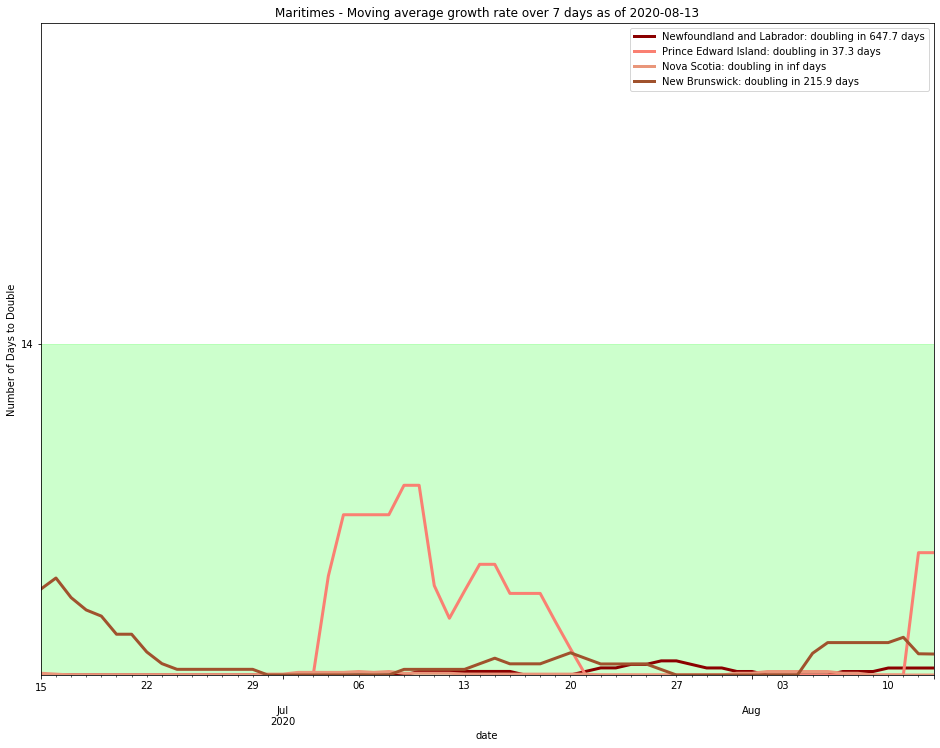

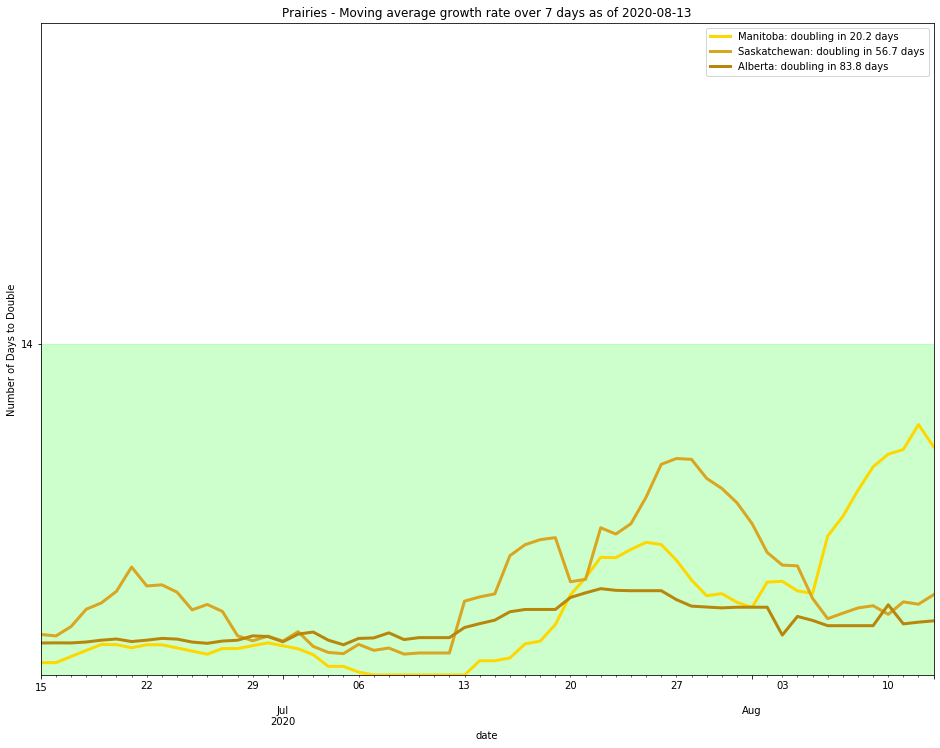

In [30]:
# Plot Data Selections
selections = [large_provinces, ['Canada', 'Ontario'], maritimes, prairies]
selection_titles = [
    "Canada and Large Provinces",
    "Canada and Ontario",
    "Maritimes",
    "Prairies"
]
title = f"Moving average growth rate over {ma_window} days as of {can_current_date}"

cur_dbl_rates = dict(zip(can_growth_df.columns, 
                         list(map(doubling_time, can_growth_df[-1:].values[0]))))

# Build Plots
num_plots = len(selections)

fig_gwt = plt.figure()
fig_gwt_ax = []


for k in range(num_plots):
    fig_gwt_ax.append(can_growth_df[-history:][selections[k]].plot( 
        figsize = (16,12),
        # logy=True, 
        title=selection_titles[k] + " - " + title,
        color=[prov_colours[prov] for prov in selections[k]],
        lw=3
    ))
    for dbl_days, dbl_rate in dbl_periods.items():
        if dbl_days == 14:
            #ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=6)
            fig_gwt_ax[k].axhspan(0, dbl_rate, color=dbl_colour(dbl_days), alpha=0.2)
        else:
            fig_gwt_ax[k].axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=3)
    
    fig_gwt_ax[k].set_yticks(list(dbl_periods.values()))
    fig_gwt_ax[k].set_yticklabels(list(dbl_periods.keys()))
    fig_gwt_ax[k].set_ylabel("Number of Days to Double")
    fig_gwt_ax[k].set_ylim(bottom=0, top=0.1)
    
    legend_labels = [f"{prov}: doubling in {cur_dbl_rates[prov]:.1f} days" for prov in selections[k]]
    plt.legend(legend_labels, loc='upper right')
    
    savefile = f"{can_current_date}_COVID-19_Growth_{ma_window}_days_{selections[k]}.png"
    plt.savefig(Path.home().joinpath("Downloads/" + savefile),
               format="png")

#fig_can_growth.title(f"Canada - Moving average growth rate over {ma_window} days")
#fig_can_growth_ax.set_ylabel("Change in Number of Cases")



plt.show()

### Graphs - Canada Growth Rate Deaths and Total Cases

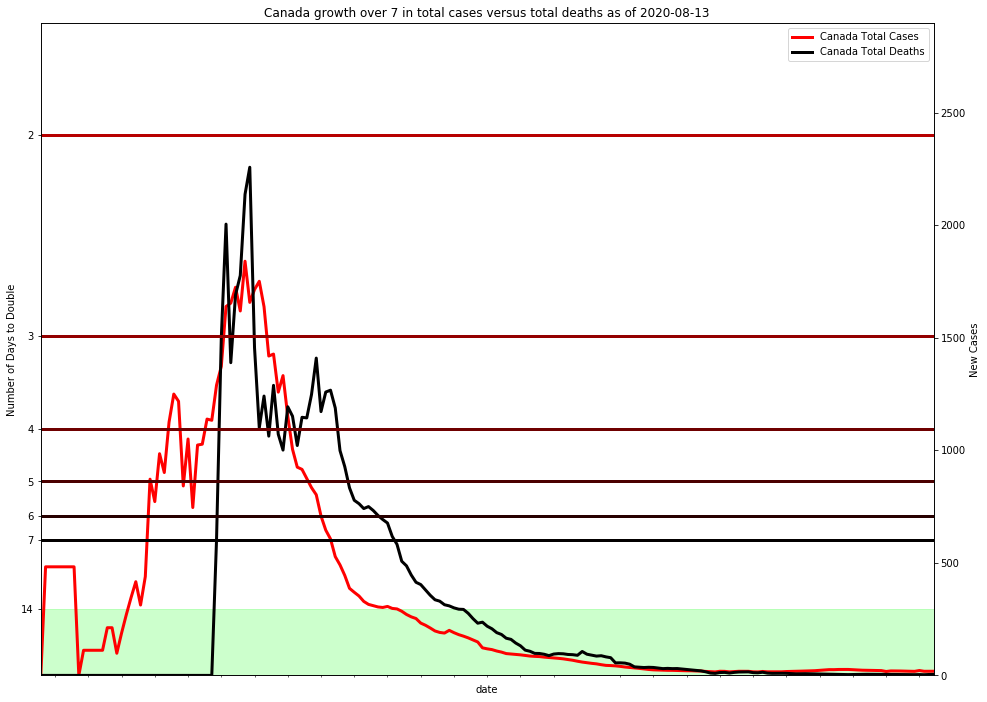

In [31]:
title = f"Moving average growth rate over {ma_window} days as of {can_current_date}"

# Build Plots
num_plots = len(selections)

loc = 'Canada'

df = can_growth_df.join(can_td_growth_df, lsuffix=' Total Cases', rsuffix=' Total Deaths')

fig_gwt_tc_vs_td_axl = df[[f"{loc} Total Cases", f"{loc} Total Deaths"]].plot(
    figsize = (16,12),
        # logy=True, 
        title=f"{loc} growth over {ma_window} in total cases versus total deaths as of {can_current_date}",
        color=['red', 'black'],
        lw=3
)

# Set up left axis
for dbl_days, dbl_rate in dbl_periods.items():
        if dbl_days == 14:
            #ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=6)
            fig_gwt_tc_vs_td_axl.axhspan(0, dbl_rate, color=dbl_colour(dbl_days), alpha=0.2)
        else:
            fig_gwt_tc_vs_td_axl.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=3)
fig_gwt_tc_vs_td_axl.set_yticks(list(dbl_periods.values()))
fig_gwt_tc_vs_td_axl.set_yticklabels(list(dbl_periods.keys()))
fig_gwt_tc_vs_td_axl.set_ylabel("Number of Days to Double")
fig_gwt_tc_vs_td_axl.set_ylim(bottom=0, top=0.5)

# Set up right axis
fig_gwt_tc_vs_td_axr = fig_gwt_tc_vs_td_axl.twinx()
fig_gwt_tc_vs_td_axr.set_ylabel("New Cases")
fig_gwt_tc_vs_td_axr.bar(
    can_nc.index.strftime('%Y-%m-%d')[ma_window:],
    can_nc[ma_window:][loc], color=(1,0,0, 0.2)
)

    
    
#savefile = f"{can_current_date}_COVID-19_Growth_tctd_{ma_window}_days_{selections[k]}.png"
#plt.savefig(Path.home().joinpath("Downloads/" + savefile),
#           format="png")


plt.show()

In [32]:
can_td[provinces]

prname,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-09,8981.0,3.0,0.0,64.0,2.0,5695.0,2786.0,8.0,20.0,208.0,195.0,0.0,0.0,0.0
2020-08-10,8987.0,3.0,0.0,64.0,2.0,5696.0,2786.0,8.0,20.0,213.0,195.0,0.0,0.0,0.0
2020-08-11,8991.0,3.0,0.0,64.0,2.0,5697.0,2786.0,8.0,20.0,216.0,195.0,0.0,0.0,0.0


### Graphs - Growth of Positive Test Rate

/Users/bill/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

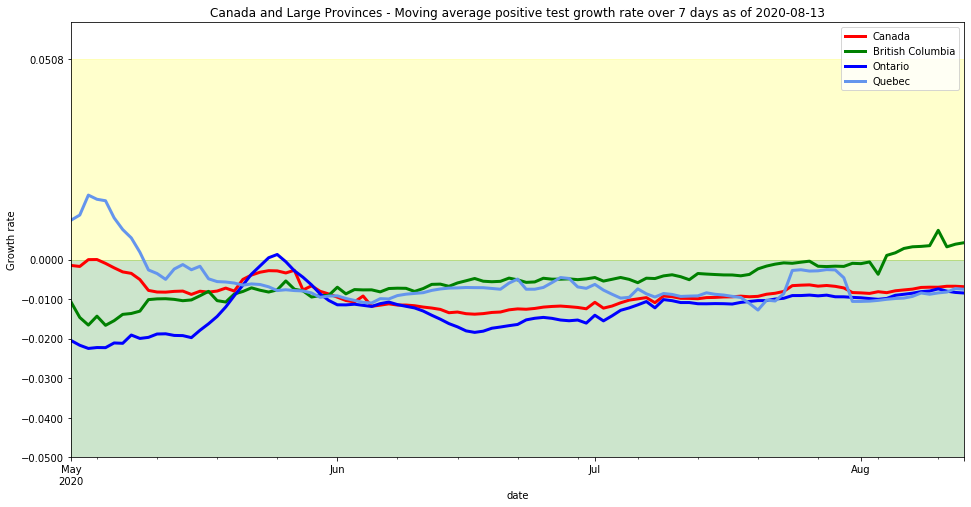

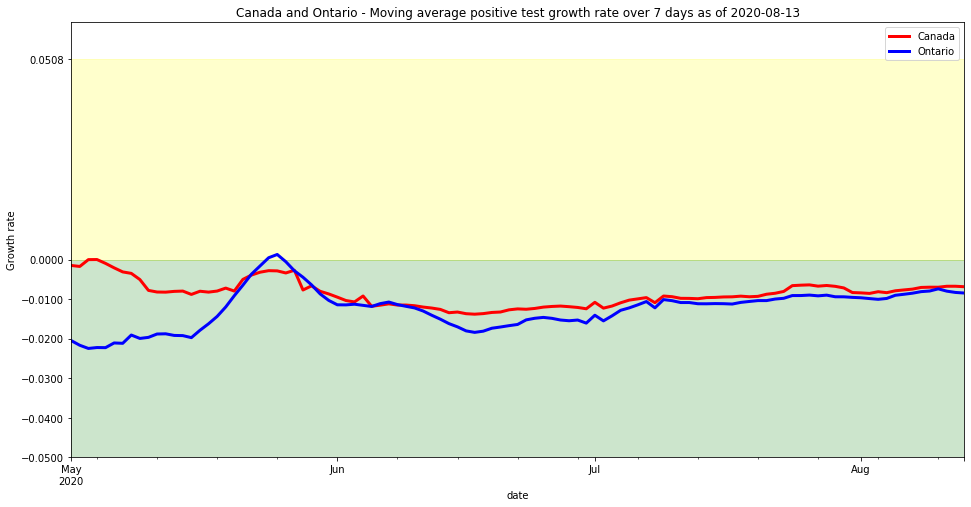

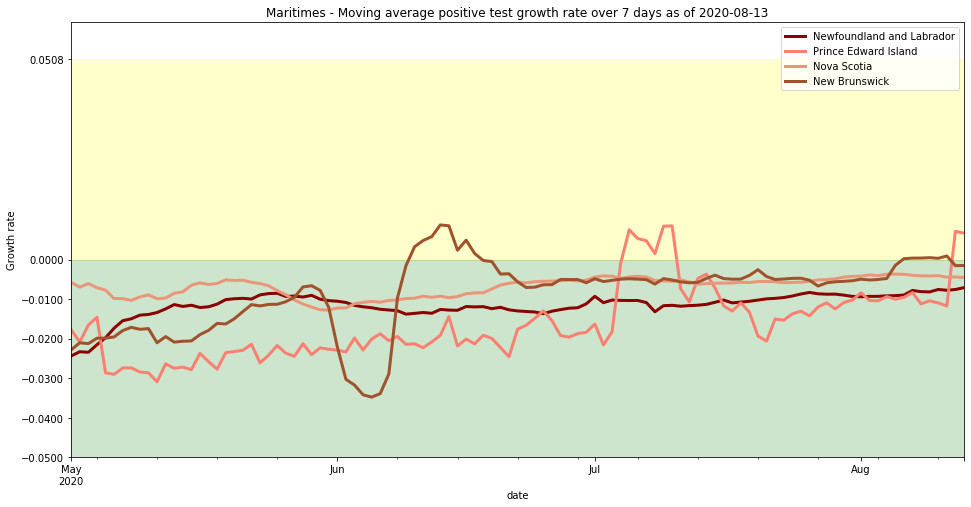

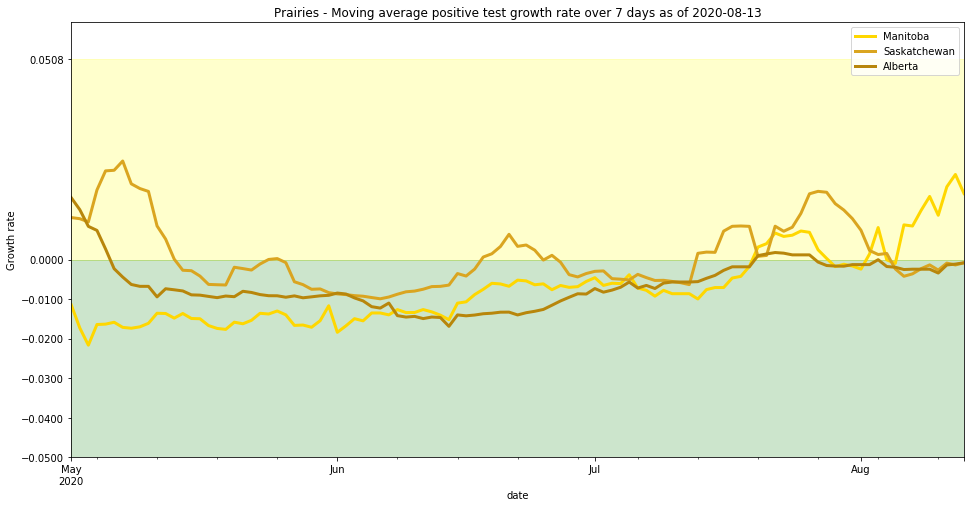

,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-08-13,-0.006876,-0.007112,0.006673,-0.004551,-0.00151,-0.007519,-0.008471,0.016689,-0.000828,-0.000826,0.004251,-0.013523,-0.004426,0.0


In [33]:
fig_pt = plt.figure()
fig_pt_ax = []
title = f"Moving average positive test growth rate over {ma_window} days as of {can_current_date}"

cur_dbl_rates = dict(zip(can_pt_growth_df.columns, 
                         list(map(doubling_time, can_pt_growth_df[-1:].values[0]))))

for k in range(num_plots):
    fig_pt_ax.append(can_pt_growth_df["2020-05-01":][selections[k]].plot( 
        figsize = (16,8),
        #logy=True, 
        title=selection_titles[k] + " - " + title,
        color=[prov_colours[prov] for prov in selections[k]],
        lw=3
    ))
    for dbl_days, dbl_rate in dbl_periods.items():
        if dbl_days == 14:
            #ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=6)
            fig_pt_ax[k].axhspan(0, dbl_rate, color='yellow', alpha=0.2)
        else:
            fig_pt_ax[k].axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=3)
    ymin, ymax = fig_pt_ax[k].get_ylim()
    fig_pt_ax[k].axhspan(-0.1, 0, color='green', alpha=0.2)
    fig_pt_ax[k].set_yticks([-0.1, -0.05, -0.04, -0.03, -0.02, -0.01, 0] + list(dbl_periods.values())[2:])
    #fig_pt_ax[k].set_yticklabels(list(dbl_periods.keys())[2:])
    fig_pt_ax[k].set_ylabel("Growth rate")
    fig_pt_ax[k].set_ylim(bottom=-0.05, top=0.06)
    
    #legend_labels = [f"{prov}: doubling in {cur_dbl_rates[prov]:.1f} days" for prov in selections[k]]
    #plt.legend(legend_labels, loc='upper right')
    
    savefile = f"{can_current_date}_COVID-19_PTGrowth_{ma_window}_days_{selections[k]}.png"
    plt.savefig(Path.home().joinpath("Downloads/" + savefile),
               format="png")
    
#fig_can_growth.title(f"Canada - Moving average growth rate over {ma_window} days")
#fig_can_growth_ax.set_ylabel("Change in Number of Cases")



plt.show()

can_pt_growth_df[-1:]

### Graphs - Canada Total Cases per Million Population

<Figure size 432x288 with 0 Axes>

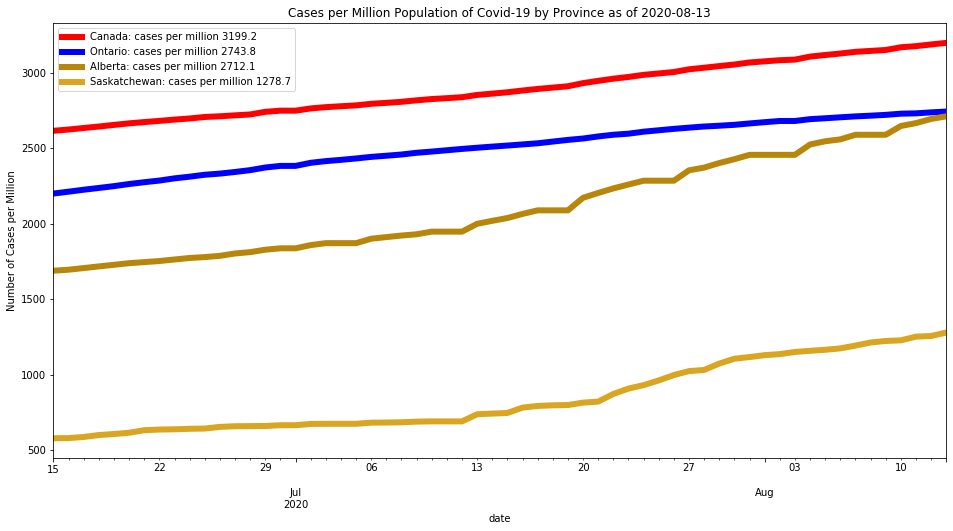

In [34]:
fig_can_tc_pm = plt.figure()
selection = ['Canada', 'Ontario', 'Alberta', 'Saskatchewan']
fig_can_tc_pm_ax = can_cases_per_mil[-history:][selection].plot(
    figsize=(16,8),  
    #logy=True,
    title=f"Cases per Million Population of Covid-19 by Province as of {can_current_date}",
    color=[prov_colours[prov] for prov in ['Canada', 'Ontario', 'Alberta', 'Saskatchewan']],
    lw=6
)

prev = {prov: list(vals.values())[-1] for prov, vals in can_cases_per_mil[-1:][selection].to_dict().items()}
legend_labels = [f"{prov}: cases per million {prev[prov]:.1f}" for prov in selection]
plt.legend(legend_labels, loc='upper left')

fig_can_tc_pm_ax.set_ylabel("Number of Cases per Million")

plt.show()

<Figure size 432x288 with 0 Axes>

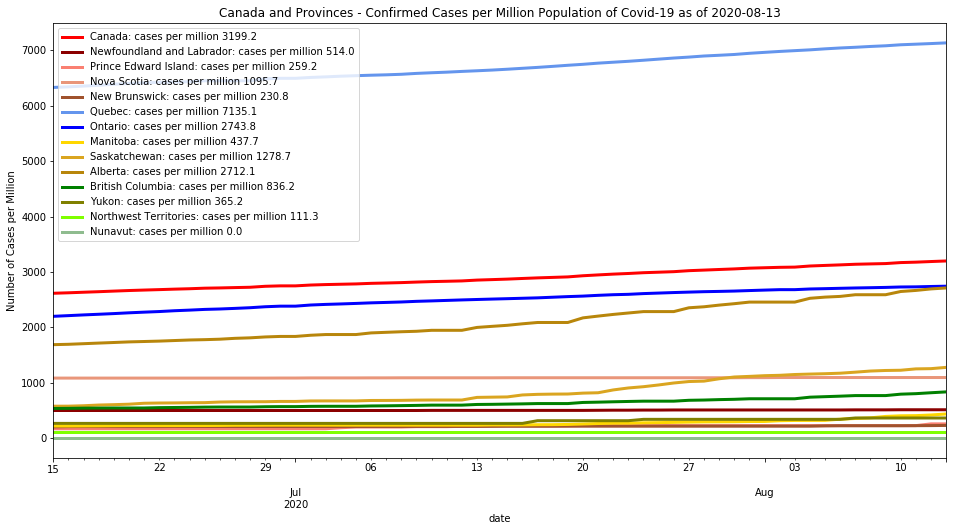

In [35]:
# Large Provinces per Million Population

fig_can_tc_pm_lp = plt.figure()
fig_can_tc_pm_lp_ax = can_cases_per_mil[-history:][provinces].plot(
    figsize=(16,8), 
    #logy=True,
    title=f"Canada and Provinces - Confirmed Cases per Million Population of Covid-19 as of {can_current_date}",
    color=[prov_colours[prov] for prov in provinces],
    lw=3
)

prev = {prov: list(vals.values())[-1] for prov, vals in can_cases_per_mil[-1:][provinces].to_dict().items()}
legend_labels = [f"{prov}: cases per million {prev[prov]:.1f}" 
                 for prov in provinces]
#                 for prov in sorted(provinces, key=lambda prov: prev[prov], reverse=True)]
plt.legend(legend_labels, loc='upper left')

fig_can_tc_pm_lp_ax.set_ylabel("Number of Cases per Million")

savefile = f"{can_current_date}_TC_per_million.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

# Ontario

In [36]:
ont_tc = can_df[can_df.prname == "Ontario"]['numtotal']
ont_tc.index = can_df[can_df.prname == "Ontario"]['date']
ont_tc = ont_tc.resample('D').fillna(method='ffill')
ont_nc = can_nc['Ontario']
ont_tc_today = ont_tc[-1]
doubled_in = len(ont_tc.loc[ont_tc > (ont_tc_today / 2)]) + 1
factor = ont_tc_today / ont_tc[-doubled_in]
double_date = str(ont_tc.index[-doubled_in].date())

In [37]:
ext_tc = np.append(ont_tc.values, [0] * 14)
ont_ac = ont_tc.values - np.array([ext_tc[k-14] for k in range(len(ont_tc))])
print(ont_ac)
# print(growth_ma(ont_ac, 14))

[   3    3    3    3    3    3    3    3    3    3    3    3    3    3
    0    0    0    0    0    0    0    0    0    0    1    1    2    3
    3    5   12   12   17   17   19   25   25   28   30   30   37   53
   73   71   88  130  157  169  236  283  349  394  469  554  646  799
  914  914 1252 1561 1789 2203 2535 2944 3253 3613 3844 4138 4588 4901
 5244 5655 5694 5764 5987 6055 6168 6270 6380 6540 6837 7009 6969 7120
 7282 7347 7383 7386 7428 7281 7226 7083 7109 6975 6739 6575 6477 6242
 6079 5949 5806 5690 5526 5508 5394 5314 5194 5100 5034 5074 5052 5066
 5030 5096 5262 5358 5284 5247 5285 5288 5220 5206 5306 5325 5273 5216
 5119 5162 5117 4956 4899 4858 4678 4516 4459 4330 4107 3845 3697 3514
 3348 3099 2859 2777 2763 2675 2661 2590 2484 2465 2541 2514 2324 2453
 2440 2355 2318 2311 2207 2162 2143 2148 2118 2069 1928 1882 1984 1793
 1739 1784 1810 1791 1882 1929 1862 1941 1949 1957 1960 1960 1934 1912
 1935 1893 1845 1710 1686 1607 1599 1492 1424 1366 1362 1284 1303 1292]


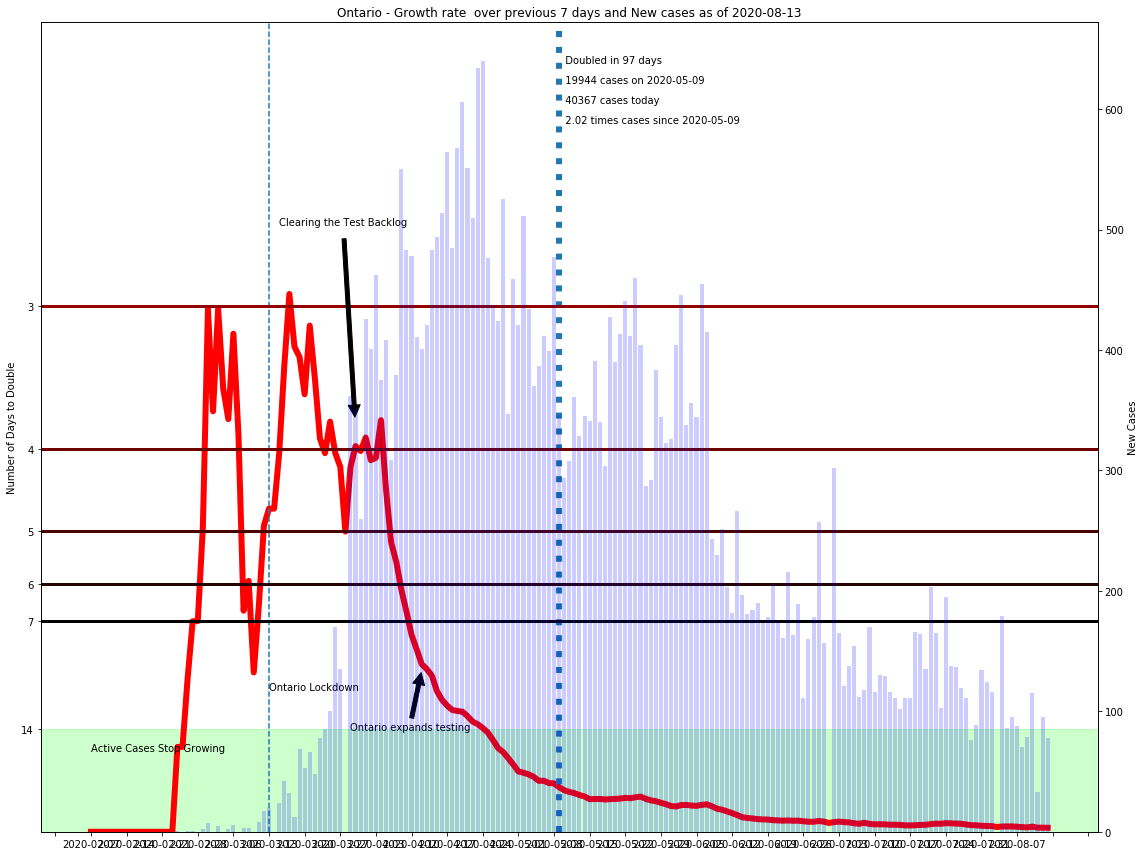

In [38]:
fig_ont = plt.figure(figsize=(16,12))
fig_ont_ax = fig_ont.add_subplot(111)

ont_window = 7

fig_ont_ax.set_title(f"Ontario - Growth rate  over previous {ont_window} days and New cases as of {can_current_date}")
fig_ont_ax.set_ylabel("daily percent growth")

dates = ont_tc.index.strftime('%Y-%m-%d')[ont_window:]
tc_growth_rate = growth_ma(ont_tc.values, ont_window)
fig_ont_ax.plot(dates, tc_growth_rate, c="Red", lw=6)
#fig_ont_ax.plot(dates, ont_ac[window:], c="Red", lw=6)

fig_ont_ax_r = fig_ont_ax.twinx()
fig_ont_ax_r.bar(dates, can_nc["Ontario"].values[ont_window:], color=(0,0,1, 0.2))
fig_ont_ax_r.set_ylabel('New Cases')

#ac_growth_rate = growth_ma(ont_ac, window)
#fig_ont_ax.plot(dates, ac_growth_rate)

fig_ont_ax.axvline(x='2020-03-13', ls='--')  # Ontario lockdown
fig_ont_ax.annotate("Ontario Lockdown", ('2020-03-13', 0.07))

fig_ont_ax.axvline(x=double_date, ls=':', lw=6)  # Ontario lockdown
fig_ont_ax.annotate(f"  Doubled in {doubled_in} days", (double_date, 0.38))
fig_ont_ax.annotate(f"  {ont_tc[-doubled_in]} cases on {double_date}", (double_date, 0.37))
fig_ont_ax.annotate(f"  {ont_tc[-1]} cases today ", (double_date, 0.36))
fig_ont_ax.annotate(f"  {factor:.2f} times cases since {double_date}", (double_date, 0.35))


    
fig_ont_ax.xaxis.set_major_locator(MultipleLocator(7))

for dbl_days, dbl_rate in dbl_periods.items():
        if dbl_days == 14:
            fig_ont_ax.axhspan(0, dbl_rate, color=dbl_colour(dbl_days), alpha=0.2)
        else:
            fig_ont_ax.axhline(y=dbl_rate, c=dbl_colour(dbl_days), lw=3)
fig_ont_ax.set_yticks(list(dbl_periods.values()))
fig_ont_ax.set_yticklabels(list(dbl_periods.keys()))
fig_ont_ax.set_ylabel("Number of Days to Double")
#fig_ont_ax.axhline(y=0.05, lw=6, c="red")
fig_ont_ax.annotate("Active Cases Stop Growing", (dates[0], 0.04))

fig_ont_ax.annotate('Clearing the Test Backlog', 
                    xy=('2020-03-30', 0.2), 
                    xytext=('2020-03-15', 0.3),
                    arrowprops=dict(facecolor='black', shrink=0.05))

fig_ont_ax.annotate('Ontario expands testing', 
                    xy=('2020-04-12', 0.08), 
                    xytext=('2020-03-29', 0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05))

#fig_ont_ax.axvline(x=datetime.date(2020,3,16), ls='--')  # Canada lockdown
#fig_ont_ax.annotate("Lockdown Begins", ('2020-03-16', 0.10))

fig_ont_ax.set_ylim(bottom=0, top=0.4)
fig_ont.tight_layout()

savefile = f"{can_current_date}_COVID-19_OntGrowthNC_{ma_window}_days.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")
plt.show()

# United States

Data from the covid tracking project:
https://covidtracking.com/api/

In [39]:
us_states_df = pd.read_csv("http://covidtracking.com/api/states/daily.csv")
us_states_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200813,AK,4750.0,289303.0,NaN,46.0,NaN,NaN,NaN,3.0,...,294053,0,0,381bf8f0e662d6e19fbe80b229d90c9a00dfb33f,0,0,0,0,0,NaN
1,20200813,AL,105557.0,697005.0,NaN,1365.0,12456.0,NaN,1292.0,NaN,...,802562,8,164,7d9b76da037e0e2f27bcbc64c059d6d263452b52,0,0,0,0,0,NaN
2,20200813,AR,51766.0,531714.0,NaN,473.0,3566.0,NaN,NaN,112.0,...,583480,16,94,54739fc8b8baa4e19b90a1795e15f6a550203e2e,0,0,0,0,0,NaN
3,20200813,AS,0.0,1396.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1396,0,0,55b13ab004429af22ff6063feddc5d9d63baaf47,0,0,0,0,0,NaN
4,20200813,AZ,190794.0,867384.0,NaN,1411.0,20503.0,497.0,NaN,334.0,...,1058178,36,682,1355f95f3a92ad97712201d848bf74ab50111002,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9028,20200126,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,0,6651e166d96764ff1a625db3688b9c547326bf8c,0,0,0,0,0,NaN
9029,20200125,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,0,32c45cbd5727e7f9570593bc23b0abb98c1efa14,0,0,0,0,0,NaN
9030,20200124,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,0,41b25b21697a9a75a314694abd65a010008238a0,0,0,0,0,0,NaN
9031,20200123,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,0,0dd03499910fd51f8661f17e97e6ef598b0c3609,0,0,0,0,0,NaN


In [40]:
us_states_info_df = pd.read_csv("https://covidtracking.com/api/states/info.csv")
us_states_info_df

,state,notes,covid19Site,covid19SiteSecondary,covid19SiteTertiary,twitter,covid19SiteOld,name,fips,pui,pum
0,AK,Negatives = (Totals – Positives)\nPositives oc...,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,https://alaska-dhss.maps.arcgis.com/apps/opsda...,@Alaska_DHSS,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,Alaska,2,NaN,False
1,AL,Negatives = (Totals - Positives) \nPositives o...,https://alpublichealth.maps.arcgis.com/apps/op...,https://dph1.adph.state.al.us/covid-19/,NaN,@alpublichealth,http://www.alabamapublichealth.gov/infectiousd...,Alabama,1,NaN,False
2,AR,NaN,https://www.healthy.arkansas.gov/programs-serv...,https://adem.maps.arcgis.com/apps/opsdashboard...,NaN,@adhpio,https://www.healthy.arkansas.gov/programs-serv...,Arkansas,5,NaN,False
3,AS,American Samoa does not have a regularly updat...,https://www.americansamoa.gov/covid-19-advisories,https://www.facebook.com/amsamgov/,NaN,NaN,http://www.samoagovt.ws/2020/03/ministry-of-he...,American Samoa,60,NaN,False
4,AZ,"Negative = Total - Positive.\n\nAs of May 8, A...",https://www.azdhs.gov/preparedness/epidemiolog...,https://tableau.azdhs.gov/views/Hospitalizatio...,https://tableau.azdhs.gov/views/ExternalEMReso...,@azdhs,https://www.azdhs.gov/preparedness/epidemiolog...,Arizona,4,NaN,False
5,CA,"Before April 1, California was inconsistent in...",https://update.covid19.ca.gov,https://public.tableau.com/views/COVID-19Cases...,https://public.tableau.com/views/COVID-19Hospi...,@CAPublicHealth,https://www.cdph.ca.gov/Programs/CID/DCDC/Page...,California,6,NaN,False
6,CO,Negative = People Tested - Cases. Cases includ...,https://covid19.colorado.gov/case-data,https://covid19.colorado.gov/covid-19-data,https://covid19.colorado.gov/hospital-data,@cdphe,https://www.colorado.gov/pacific/cdphe/2019-no...,Colorado,8,NaN,False
7,CT,Negative = Total - Positive. \nPositives occa...,https://data.ct.gov/coronavirus,NaN,NaN,@ctdph,https://portal.ct.gov/Coronavirus,Connecticut,9,NaN,False
8,DC,Positive and Negative include both public and ...,https://coronavirus.dc.gov/page/coronavirus-su...,NaN,NaN,@_DCHealth,https://coronavirus.dc.gov/,District Of Columbia,11,NaN,False
9,DE,"As of April 27, Delaware is reporting people t...",https://dhss.delaware.gov/dhss/dph/epi/2019nov...,NaN,NaN,@Delaware_DHSS,https://dhss.delaware.gov/dhss/dph/epi/2019nov...,Delaware,10,NaN,False


In [41]:
Path.cwd()

PosixPath('/Users/bill/IdeaProjects/covid-19')

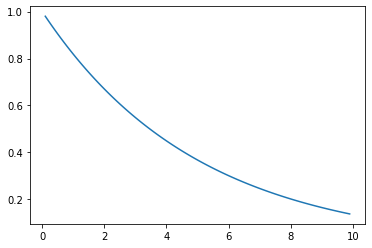

In [42]:
X = [x / 10 for x in range(1, 100)]
Y = [1 / np.exp(0.2*x) for x in X]

plt.plot(X, Y)
    
plt.show()